# Validation

Validation cases of CCBlade's functionalities.

In [1]:
import CSV
import Dierckx
using PyPlot

using CCBlade

## Distributed Load - Ballard's Hovering Rotor

* **Description:** Comparison of CCBlade's predicted distributed load to experimental data on a rotor of simple geometry.
* **Data source:** Ballard, J. D., Orloff, K. L., & Luebs, A. B. (1979). Effect of Tip Planform on Blade Loading Characteristics for a Two-Bladed Rotor in Hover. Figures 9 and 10 (see images below).
* **Configuration:** Rectangular two-bladed rotor. Tip Reynolds number of $4\times10^5$ and Mach number of 0.22 at 700 RPM. Static test (no inflow other than induced). Collective pitch of $9.8^\circ$

|  |  |
| ------ | ----------- |
| <img src="figures/ballard00.png" alt="Pic here" width="350px"/>  | <img src="figures/ballard01.png" alt="Pic here" width="350px"/> |
| <img src="figures/ballard04.png" alt="Pic here" width="350px"/> | <img src="figures/ballard05.png" alt="Pic here" width="350px"/> |

### Model Definition

In [2]:

# ------------------ SIMULATION SETUP ----------------------

# Operation parameters
rho = 1.225             # (kg/m^3) air density
Vinf = 0.0              # (m/s) freestream
Omega = 73.3            # (rad/s) rotor angular speed
pitch = 9.8             # (deg) blade pitch

# Geometric parameters
B = 2                   # Number of blades
Rtip = 1.05             # (m) blade radius
Rhub = 0.134*Rtip       # (m) hub radius
twistroot = 6.5         # (deg) twist at root
twisttip = -3.0         # (deg) twist at tip
chordroot = 0.0726*Rtip # (m) chord at root
chordtip = 1.0*chordroot# (m) chord at tip
precone = 1.5*pi/180    # (rad) blade precone
n = 30                  # Number of elements (not including tip and root)

# Geometry definition
                                                # Radial positions
r = [Rhub + i*(Rtip-Rhub)/(n+1) for i in 0:n+1 if !(i in [0, n+1])]
                                                # Chord at each position
chord = [chordroot + (chordtip-chordroot)*(ri-Rhub)/(Rtip-Rhub) for ri in r]
                                                # (rad) eff twist at each position
theta = pitch + [twistroot + (twisttip-twistroot)*(ri-Rhub)/(Rtip-Rhub) for ri in r]
theta = pi/180.0*theta
af = Array{AirfoilData}(n)                      # Airfoil properties
            
for i in 1:n
    # Reads the airfoil data that has been pre-calculated with airfoilprep.py
    r_over_R = Int(round(r[i]/Rtip, 3)*1000)
    c_over_r = Int(round(chord[i]/r[i], 3)*1000)
                
    # Read file
    file_name = "roR$r_over_R-$cor$c_over_r-tsrNull"
    file_name = "naca0012-"*file_name*".csv"
    data = CSV.read(joinpath("airfoils/naca0012",file_name), datarow=2)
    
    # Convert to AirfoilData object
    af[i] = af_from_data(data[1], data[2], data[3])
end

# Inflow definition
inflow = simpleinflow(Vinf, Omega, r, precone, rho)
            
# Rotor definition
rotor = Rotor(r, chord, theta, af, Rhub, Rtip, B, precone)
            
# ------------------ RUN CCBLADE ---------------------------
turbine = false
Np, Tp, uvec, vvec = distributedloads(rotor, inflow, turbine);

### Verification

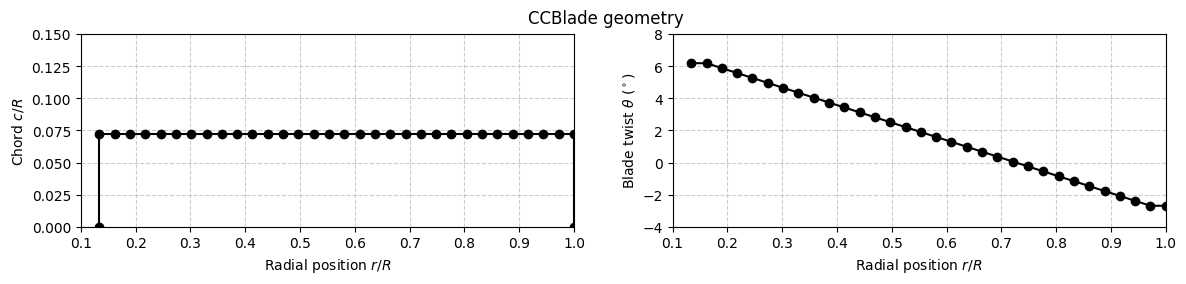

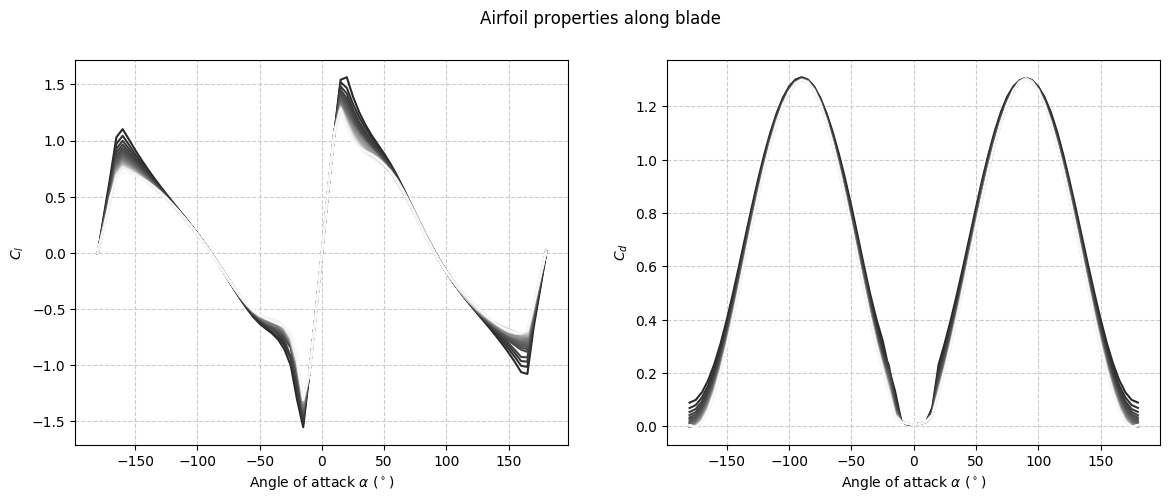

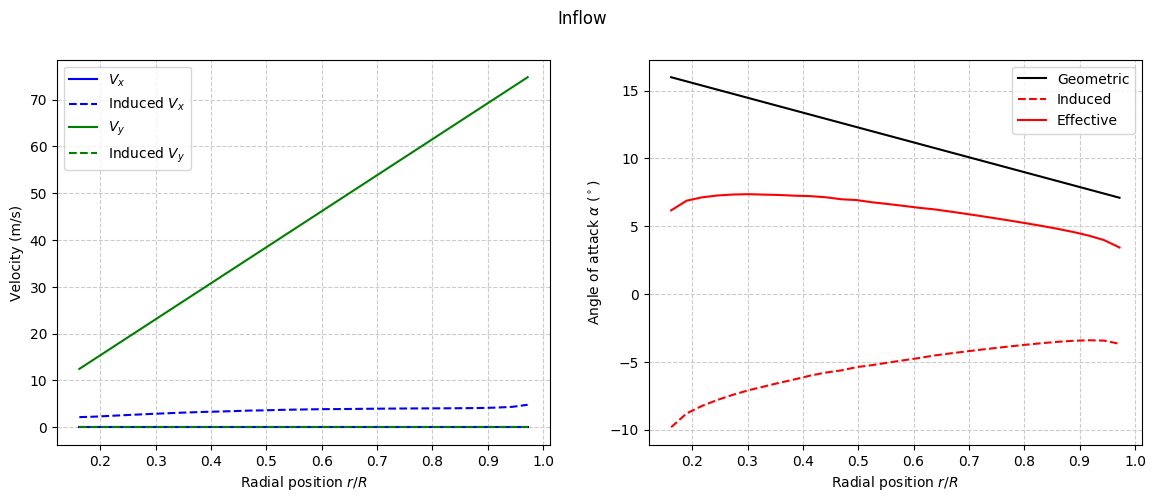

In [10]:
            
# ------------------ PLOTS ---------------------------------
            
# Plots geometry for verification
fig0 = figure("geometry", figsize=(7*2, 2.5*1))
suptitle("CCBlade geometry")

## Chord along blade
subplot(121)
plot(vcat([rotor.Rhub, rotor.Rhub], rotor.r, [rotor.Rtip, rotor.Rtip])/rotor.Rtip, 
    vcat([0, rotor.chord[1]], rotor.chord, [rotor.chord[end], 0])/rotor.Rtip, "o-k")
xlim([0.1, 1])
ylim([0, 0.15])
xlabel(L"Radial position $r/R$")
ylabel(L"Chord $c/R$")
grid(true, color="0.8", linestyle="--")

## Twist along blade
subplot(122)
plot(vcat([rotor.Rhub], rotor.r, [rotor.Rtip])/rotor.Rtip, 
    vcat([rotor.theta[1]], rotor.theta, [rotor.theta[end]])*180/pi-pitch, "o-k")
xlim([0.1, 1])
ylim([-4, 8])
xlabel(L"Radial position $r/R$")
ylabel(L"Blade twist $\theta$ ($^\circ$)")
grid(true, color="0.8", linestyle="--")



# Plots airfoil data used at each radial position
alphas = [i for i in -180:5:180]
fig1 = figure("airfoil_data", figsize=(7*2, 5*1))
suptitle("Airfoil properties along blade")
            
for (i,this_af) in enumerate(af)
    subplot(121)
    plot(alphas, [this_af.cl(a*pi/180) for a in alphas], "$(r[i]/Rtip)")
    subplot(122)
    plot(alphas, [this_af.cd(a*pi/180) for a in alphas], "$(r[i]/Rtip)")
end
            
subplot(121)
xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
ylabel(L"C_l")
grid(true, color="0.8", linestyle="--")
# xlim([-20, 20])
subplot(122)
xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
ylabel(L"C_d")
grid(true, color="0.8", linestyle="--")
          


# Plots inflow
fig3 = figure("inflow", figsize=(7*2, 5*1))
suptitle("Inflow")
subplot(121)
plot(rotor.r/rotor.Rtip, inflow.Vx, "-b", label=L"V_x")
plot(rotor.r/rotor.Rtip, uvec, "--b", label=L"Induced $V_x$")
plot(rotor.r/rotor.Rtip, inflow.Vy, "-g", label=L"V_y")
plot(rotor.r/rotor.Rtip, vvec, "--g", label=L"Induced $V_y$")
xlabel(L"Radial position $r/R$")
ylabel("Velocity (m/s)")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

# Plots effective angle of attack
subplot(122)
plot(rotor.r/rotor.Rtip, 180/pi*theta, "-k", label="Geometric")
plot(rotor.r/rotor.Rtip, 
        -180/pi*(atan2.(inflow.Vx+uvec, inflow.Vy+vvec)),
        "--r", label="Induced")
plot(rotor.r/rotor.Rtip, 
        180/pi*(theta-atan2.(inflow.Vx+uvec, inflow.Vy+vvec)),
        "-r", label="Effective")
xlabel(L"Radial position $r/R$")
ylabel(L"Angle of attack $\alpha$ ($^\circ$)")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

### Results

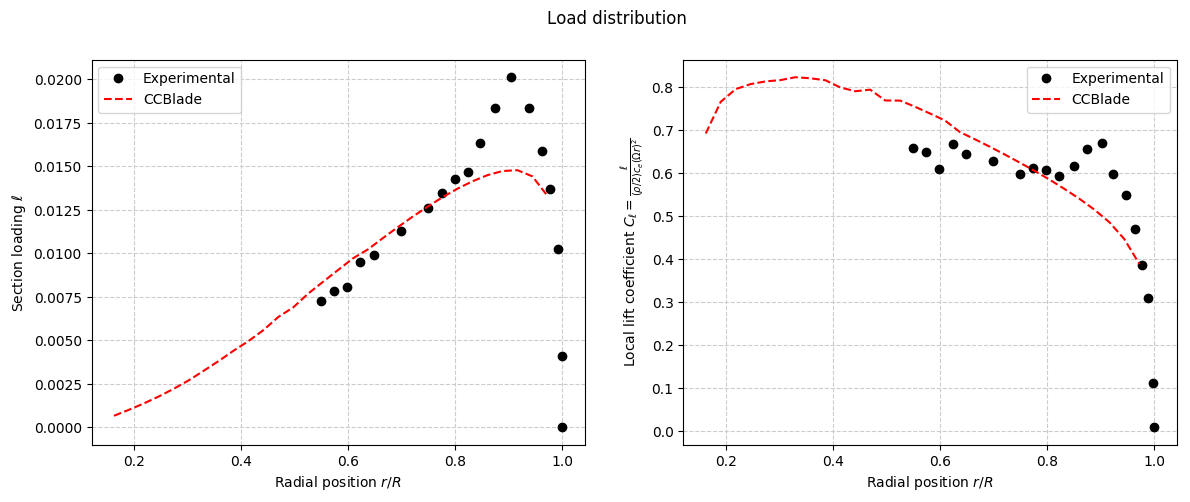

In [9]:
# Calculates lifting force on CCBlade
## Effective inflow vectors
Veff = [[inflow.Vy[i]+vvec[i], inflow.Vx[i]+uvec[i], 0] for i in 1:n]
unitVeff = [ V/norm(V) for V in Veff]
## Lift force
unitLift = [cross(V, [0,0,1]) for V in unitVeff]
Lift = [ dot([Tp[i], -Np[i], 0], unitLift[i])  for i in 1:n]

# Plots experimental vs CCBlade

## Reads experimental
exp_data_l = CSV.read("data/ballard-l.csv", datarow=1)
exp_data_cl = CSV.read("data/ballard-cl.csv", datarow=1)
            
## Nondimensionalizes CCBlade
ccb_data_l = zeros(Float64, n, 2)
ccb_data_l[:, 1] = r/Rtip
non_dim_l = rho*Omega^2*Rtip^3
# ccb_data_l[:, 2] = Np./non_dim_l
ccb_data_l[:, 2] = Lift./non_dim_l

ccb_data_cl = zeros(Float64, n, 2)
ccb_data_cl[:, 1] = r/Rtip
non_dim_cl = (rho/2)*mean(chord)*(Omega*r).^2
# ccb_data_cl[:, 2] = Np./non_dim_cl
ccb_data_cl[:, 2] = Lift./non_dim_cl

## Plots
fig2 = figure("load_distribution", figsize=(7*2, 5*1))
suptitle("Load distribution")
            
subplot(121)
plot(exp_data_l[1], exp_data_l[2], "ok", label="Experimental")
plot(ccb_data_l[:, 1], ccb_data_l[:, 2], "--r", label="CCBlade")
xlabel(L"Radial position $r/R$")
ylabel(L"Section loading $\ell$")
legend(loc="best")
grid(true, color="0.8", linestyle="--")
            
subplot(122)
plot(exp_data_cl[1], exp_data_cl[2], "ok", label="Experimental")
plot(ccb_data_cl[:, 1], ccb_data_cl[:, 2], "--r", label="CCBlade")
xlabel(L"Radial position $r/R$")
ylabel(L"Local lift coefficient $C_\ell = \frac{\ell}{(\rho/2)c_e(\Omega r)^2}$")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

The section loading $\ell$ compares relatively well with the prescribed-wake method analyzed in Ballard's report:

|  |  |
| ------ | ----------- |
| <img src="figures/ballard02.png" alt="Pic here" width="500px"/>  | <img src="figures/ballard03.png" alt="Pic here" width="600px"/> |

From the Kutta–Joukowski theorem, the circulation around the airfoil cross section at each radial position can be calculated as

\begin{align}
    \Gamma = -\frac{\ell}{\rho V_\infty}
,\end{align}
where $V_\infty$ is the inflow at each radial position.

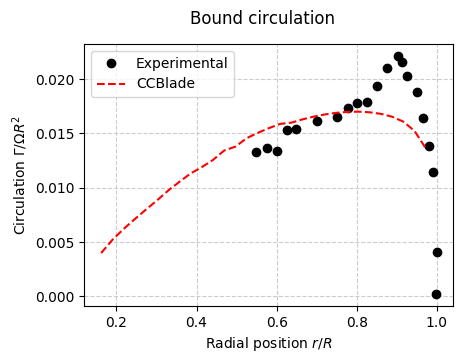

In [15]:

## Reads experimental
exp_data_gamma = CSV.read("data/ballard-gamma.csv", datarow=1)
            
## Nondimensionalizes CCBlade
ccb_data_gamma = zeros(Float64, n, 2)
ccb_data_gamma[:, 1] = r/Rtip
non_dim_gamma = Omega*Rtip^2
ccb_data_gamma[:, 2] = Np./(rho*inflow.Vy) ./ non_dim_gamma

## Plots
fig4 = figure("circulation", figsize=(7*0.68, 5*0.68))
suptitle("Bound circulation")
            
subplot(111)
plot(exp_data_gamma[1], exp_data_gamma[2], "ok", label="Experimental")
plot(ccb_data_gamma[:, 1], ccb_data_gamma[:, 2], "--r", label="CCBlade")
xlabel(L"Radial position $r/R$")
ylabel(L"Circulation $\Gamma/\Omega R^2$")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

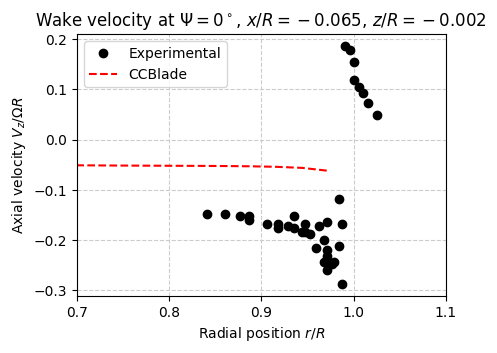

PyObject <matplotlib.legend.Legend object at 0x7fb31d8687d0>

In [17]:
# Axially induced velocity
header = ["r_over_R", "Vz_over_rotV"]
data_vel0 = CSV.read( "data/ballard-vel0.csv",
                              datarow=1, header=header )
fig5 = figure("vel", figsize=(7*0.68, 5*0.68))
title(L"Wake velocity at $\Psi=0^\circ$, $x/R=-0.065$, $z/R=-0.002$")
plot(data_vel0[:,1], data_vel0[:,2], "ok", label="Experimental")
plot(r/Rtip, -uvec/(Omega*Rtip), "--r", label="CCBlade")
xlabel(L"Radial position $r/R$")
ylabel(L"Axial velocity $V_z/\Omega R$")
xlim([0.7, 1.1])
grid(true, color="0.8", linestyle="--")
legend(loc="best")

**Conclusion:** Good prediction of section loading towards the center of the blade, but poor prediction towards the tip.

## Distributed Load - Caradonna's Hovering Rotor

* **Description:** Comparison of CCBlade's predicted distributed load to experimental data on a rotor of simple geometry.
* **Data source:** Caradonna, F. X., & Tung, C. (1981). Experimental and Analytical Studies of a Model Helicopter Rotor in Hover. NASA Technical Memorandum (Vol. 81232). Figures 14 and 16.
* **Configuration:** Rectangular two-bladed rotor. Half degree precone. NACA 0012 profile, untwisted, untapered. Aspect ratio 6. Two measurements at collective pitch of $5^\circ$ and $8^\circ$. Tip Reynolds of $1.8\times10^6$ and Mach number of $0.44$.

<img src="figures/caradonna02.png" alt="Pic here" width="350px"/>

|  |  |
| ------ | ----------- |
| <img src="figures/caradonna00.png" alt="Pic here" width="350px"/>   | <img src="figures/caradonna01.png" alt="Pic here" width="350px"/>|

### Model Definition

In [3]:
# ------------------ SIMULATION SETUP ----------------------

# Geometric parameters
B = 2                   # Number of blades
AR = 6                  # Aspect ratio
Rtip = 2.286/2          # (m) blade radius
Rhub = 0.254*3/2        # (m) hub radius
twistroot = 0           # (deg) twist at root
twisttip = 0            # (deg) twist at tip
chordroot = Rtip/AR     # (m) chord at root
chordtip = 1.0*chordroot# (m) chord at tip
precone = 0.5*pi/180    # (rad) blade precone
n = 30                  # Number of elements (not including tip and root)

# Operation parameters
rho = 1.225             # (kg/m^3) air density
Vinf = 0.0              # (m/s) freestream
Omega = 150/Rtip        # (rad/s) rotor angular speed
pitchs = [8, 5]         # (deg) blade pitch

# Geometry definition
                                                # Radial positions
r = [Rhub + i*(Rtip-Rhub)/(n+1) for i in 0:n+1 if !(i in [0, n+1])]
                                                # Chord at each position
chord = [chordroot + (chordtip-chordroot)*(ri-Rhub)/(Rtip-Rhub) for ri in r]
af = Array{AirfoilData}(n)                      # Airfoil properties

for i in 1:n
    # Reads the airfoil data that has been pre-calculated with airfoilprep.py
    r_over_R = Int(round(r[i]/Rtip, 3)*1000)
    c_over_r = Int(round(chord[i]/r[i], 3)*1000)

    # Read file
    file_name = "roR$r_over_R-$cor$c_over_r-tsrNull"
    file_name = "naca0012_2-"*file_name*".csv"
    data = CSV.read(joinpath("airfoils/naca0012",file_name), datarow=2)
#     data = CSV.read("airfoils/naca0012/naca0012_2-orig.csv", datarow=2)

    # Convert to AirfoilData object
    af[i] = af_from_data(data[1], data[2], data[3])
end

            
# RUNS FOR EACH PITCH VALUE
Nps, Tps, uvecs, vvecs, thetas = [Array{Float64,1}[] for i in 1:5]
rotors, inflows = [], []
for pitch in pitchs
                
    # (rad) eff twist at each position
    theta = pitch + [twistroot + (twisttip-twistroot)*(ri-Rhub)/(Rtip-Rhub) for ri in r]
    theta = pi/180.0*theta

    # Inflow definition
    inflow = simpleinflow(Vinf, Omega, r, precone, rho)

    # Rotor definition
    rotor = Rotor(r, chord, theta, af, Rhub, Rtip, B, precone)

    # ------------------ RUN CCBLADE ---------------------------
    turbine = false
    Np, Tp, uvec, vvec = distributedloads(rotor, inflow, turbine);
                
    push!(Nps, Np)
    push!(Tps, Tp)
    push!(uvecs, uvec)
    push!(vvecs, vvec)
    push!(thetas, theta)
    push!(rotors, rotor)
    push!(inflows, inflow)
end

### Verification

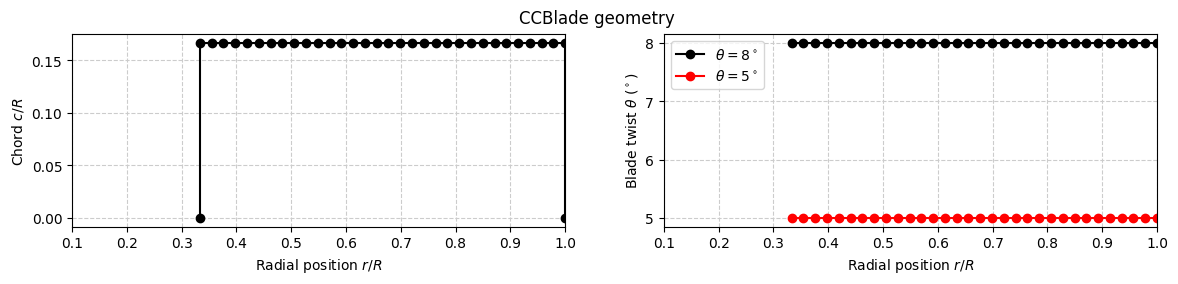

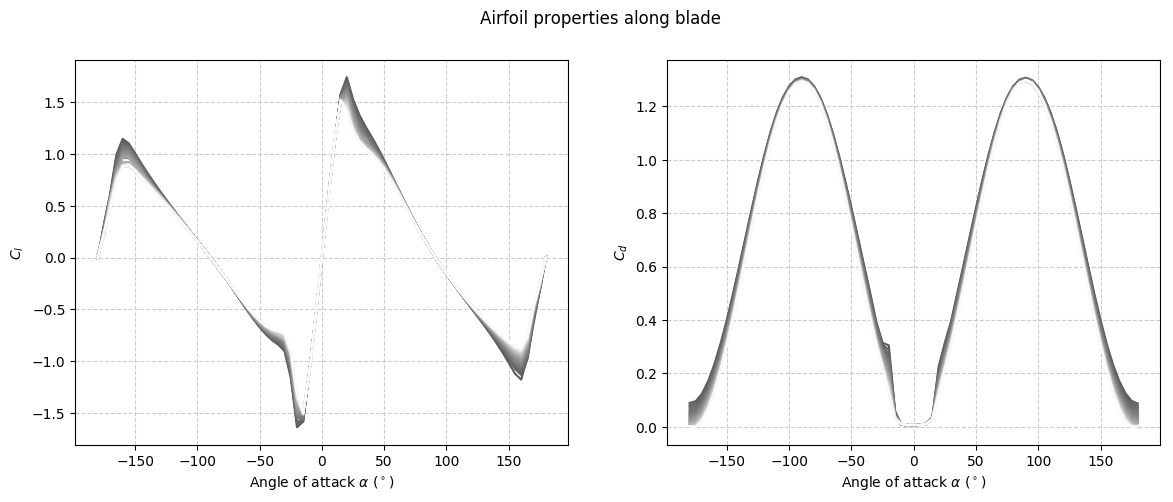

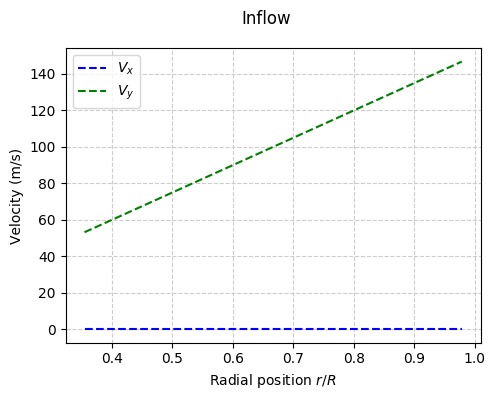

In [67]:
            
# ------------------ PLOTS ---------------------------------
            
# Plots geometry for verification
fig0 = figure("geometry", figsize=(7*2, 2.5*1))
suptitle("CCBlade geometry")

## Chord along blade
subplot(121)
plot(vcat([rotors[1].Rhub, rotors[1].Rhub], rotors[1].r, [rotors[1].Rtip, rotors[1].Rtip])/rotors[1].Rtip, 
    vcat([0, rotors[1].chord[1]], rotors[1].chord, [rotors[1].chord[end], 0])/rotors[1].Rtip, "o-k")
xlim([0.1, 1])
# ylim([0, 0.15])
xlabel(L"Radial position $r/R$")
ylabel(L"Chord $c/R$")
grid(true, color="0.8", linestyle="--")

## Twist along blade
subplot(122)
plot(vcat([rotors[1].Rhub], rotors[1].r, [rotors[1].Rtip])/rotors[1].Rtip, 
    vcat([rotors[1].theta[1]], rotors[1].theta, [rotors[1].theta[end]])*180/pi, 
    "o-k", label=L"\theta = 8^\circ")
plot(vcat([rotors[2].Rhub], rotors[2].r, [rotors[2].Rtip])/rotors[2].Rtip, 
    vcat([rotors[2].theta[1]], rotors[2].theta, [rotors[2].theta[end]])*180/pi, 
    "o-r", label=L"\theta = 5^\circ")
xlim([0.1, 1])
# ylim([-4, 8])
xlabel(L"Radial position $r/R$")
ylabel(L"Blade twist $\theta$ ($^\circ$)")
grid(true, color="0.8", linestyle="--")
legend(loc="best")



# Plots airfoil data used at each radial position
alphas = [i for i in -180:5:180]
fig1 = figure("airfoil_data", figsize=(7*2, 5*1))
suptitle("Airfoil properties along blade")
            
for (i,this_af) in enumerate(af)
    subplot(121)
    plot(alphas, [this_af.cl(a*pi/180) for a in alphas], "$(r[i]/Rtip)")
    subplot(122)
    plot(alphas, [this_af.cd(a*pi/180) for a in alphas], "$(r[i]/Rtip)")
end
            
subplot(121)
xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
ylabel(L"C_l")
grid(true, color="0.8", linestyle="--")
subplot(122)
xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
ylabel(L"C_d")
grid(true, color="0.8", linestyle="--")


# Plots inflow
fig3 = figure("inflow", figsize=(7*0.765, 5*0.765))
suptitle("Inflow")

subplot(111)
plot(rotors[1].r/Rtip, inflows[1].Vx, "--b", label=L"V_x")
plot(rotors[1].r/Rtip, inflows[1].Vy, "--g", label=L"V_y")
xlabel(L"Radial position $r/R$")
ylabel("Velocity (m/s)")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

### Results

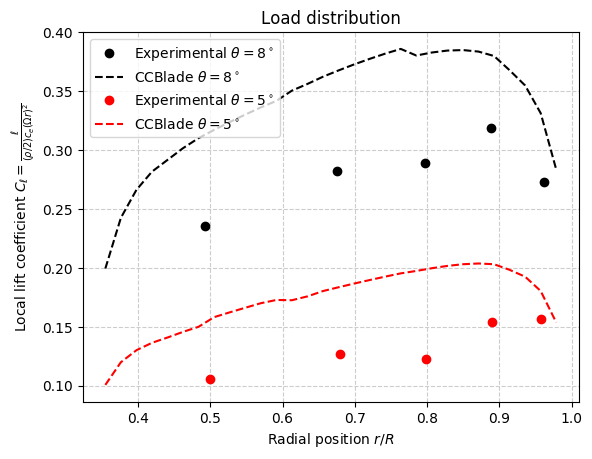

PyObject <matplotlib.text.Text object at 0x7fc5add554d0>

In [93]:
# Plots experimental vs CCBlade

## Reads experimental
exp_data_8deg = CSV.read("data/caradonna-8deg.csv", datarow=1)
exp_data_5deg = CSV.read("data/caradonna-5deg.csv", datarow=1)
            
## Nondimensionalizes CCBlade
ccb_data_cl = zeros(Float64, n, 3)
ccb_data_cl[:, 1] = r/Rtip
non_dim_cl = (rho/2)*mean(chord)*(Omega*r).^2
ccb_data_cl[:, 2] = Nps[1]./non_dim_cl
ccb_data_cl[:, 3] = Nps[2]./non_dim_cl

## Plots            
plot(exp_data_8deg[1], exp_data_8deg[2], "ok", label=L"Experimental $\theta=8^\circ$")
plot(ccb_data_cl[:, 1], ccb_data_cl[:, 2], "--k", label=L"CCBlade $\theta=8^\circ$")
plot(exp_data_5deg[1], exp_data_5deg[2], "or", label=L"Experimental $\theta=5^\circ$")
plot(ccb_data_cl[:, 1], ccb_data_cl[:, 3], "--r", label=L"CCBlade $\theta=5^\circ$")
xlabel(L"Radial position $r/R$")
ylabel(L"Local lift coefficient $C_\ell = \frac{\ell}{(\rho/2)c_e(\Omega r)^2}$")
legend(loc=2)
grid(true, color="0.8", linestyle="--")
title("Load distribution")

## Performance - APC 10x7 Propeller

* **Description:** Comparison of CCBlade's predicted performance on a hobby 10-inch propeller (APC 10x7 Thin Electric) to experimental data.
* **Data source:** McCrink, M. H., & Gregory, J. W. (2017). *Blade Element Momentum Modeling of Low-Reynolds Electric Propulsion Systems*.
* **Configuration:** Two-bladed propeller. Performance sweep on advance ratio excluding the case $J=0$. $\text{Re}_D = \frac{V{\tiny(r=0.7R)}D}{\nu}=1.5\times10^6$, $9400\text{ RPM}$, $\text{Ma}_\text{tip} = 0.36$.


<img src="figures/apc01.png" alt="Pic here" width="200px"/>

### Geometry

The following images describe the geometry of the blade as decribed by McCrink.


<img src="figures/apc00.png" alt="Pic here" width="500px"/>
<img src="figures/apc02.png" alt="Pic here" width="600px"/>

McCrink states: *The propellers use the Clark Y airfoil section from 0 to 5% span, and the NACA 4412 for the remainder of the span*. If highly doubt that the blade has the same NACA 4412 as they affirm, but their computational results using that assumption match the experimental data fairly well, so we will here follow their footsteps. In this simulation we will ignore the 5% section near the root and model only the NACA 4412 outer section.

We will use the same NACA 4412 aerodynamic properties at $\text{Re}=1.5\times10^6$ shown in McCrink's paper:

<img src="figures/apc03.png" alt="Pic here" width="800px"/>

### Model Definition

In [110]:
# ------------------ SIMULATION SETUP ----------------------

# Operation parameters
D = 10*0.0254           # (m) propeller diameter
ReD = 1.5e6             # Reynolds number of relative velocity at r/R=0.7
rho = 1.225             # (kg/m^3) air density
mu = 1.81e-5            # (kg/ms) air dynamic viscosity
sndspd = 343            # (m/s) air speed of sound
Omega = ReD*(mu/rho)/(0.7*D^2/2)      # (rad/s) propeller angular speed
RPM = Omega/(2*pi)*60   # Revs per minute
Matip = Omega*D/2/sndspd# Mach number of tip
Js = collect(linspace(0.05, 1.0, 20)[1:end-7]) # Sweep of advance ratio
Js = vcat(Js, collect(linspace(0.7, 0.85, 7)))

println("Angular velocity:\t$(round(Omega,2)) (rad/s)")
println("Revs per minute:\t$(round(RPM,0)) RPM")
println("Tip Mach number:\t$(round(Matip,2))")


# Geometric parameters
B = 2                   # Number of blades
Rtip = D/2              # (m) blade radius
Rhub = 0.05*Rtip        # (m) hub radius
precone = 0*pi/180      # (rad) blade precone
n = 30                  # Number of elements (not including tip and root)

# Geometry definition
r = collect(linspace(Rhub, Rtip, n+2)[2:end-1]) # (m) radial positions

data_chord = CSV.read("data/apc10x7_chord.csv", header=["r","c"], datarow=1)
data_twist = CSV.read("data/apc10x7_twist.csv", header=["r","theta"], datarow=1)
spl_chord = Dierckx.Spline1D(data_chord[1], data_chord[2]; k=5, s=0.01)
spl_theta = Dierckx.Spline1D(data_twist[1], data_twist[2]; k=3, s=0.01)
                                                
chord = [spl_chord(ri) for ri in r]             # (m) chord at each position
theta = pi/180*[spl_theta(ri) for ri in r]      # (rad) geometric twist at each position

            
# ------------------ RUN CCBLADE ---------------------------
turbine = false

# Sweeps on J
uvecs, vvecs, afs = [], [], []
etas, CTs, CQs = [zeros(Js) for i in 1:3]
inflows = []
for (j,J) in enumerate(Js)
    Vinf = J*Omega/(2*pi)*D                     # (m/s) freestream velocity
    tsr = pi/J                                  # Tip speed ratio
    af = Array{AirfoilData}(n)                  # Airfoil properties along blade
    
    # Reads the airfoil data that has been pre-calculated with airfoilprep.py
    for i in 1:n
        
#         tsr = Omega*r[i]/Vinf                 # Tip speed ratio
        r_over_R = Int(round(r[i]/Rtip, 3)*1000)
        c_over_r = Int(round(chord[i]/r[i], 3)*1000)

        # Read file
        file_name = "roR$r_over_R-$cor$c_over_r-tsr$(Int(round(round(tsr,3)*1000,0)))"
        file_name = "naca4412-"*file_name*".csv"
        data = CSV.read(joinpath("airfoils/naca4412",file_name), datarow=2)

        # Convert to AirfoilData object
        af[i] = af_from_data(data[1], data[2], data[3])
    end
    
    # Inflow definition
    inflow = simpleinflow(Vinf, Omega, r, precone, rho)

    # Rotor definition
    rotor = Rotor(r, chord, theta, af, Rhub, Rtip, B, precone)
    
    # RUNS CCBlade
    Np, Tp, uvec, vvec = distributedloads(rotor, inflow, turbine)
    T, Q = thrusttorque(rotor, [inflow], turbine)
    etas[j], CTs[j], CQs[j] = nondim(T, Q, Vinf, Omega, rho, Rtip, precone, turbine)
    
    push!(uvecs, uvec)
    push!(vvecs, vvec)
    push!(afs, af)
    push!(inflows, inflow)
end


Angular velocity:	981.52 (rad/s)
Revs per minute:	9373.0 RPM
Tip Mach number:	0.36


### Verification

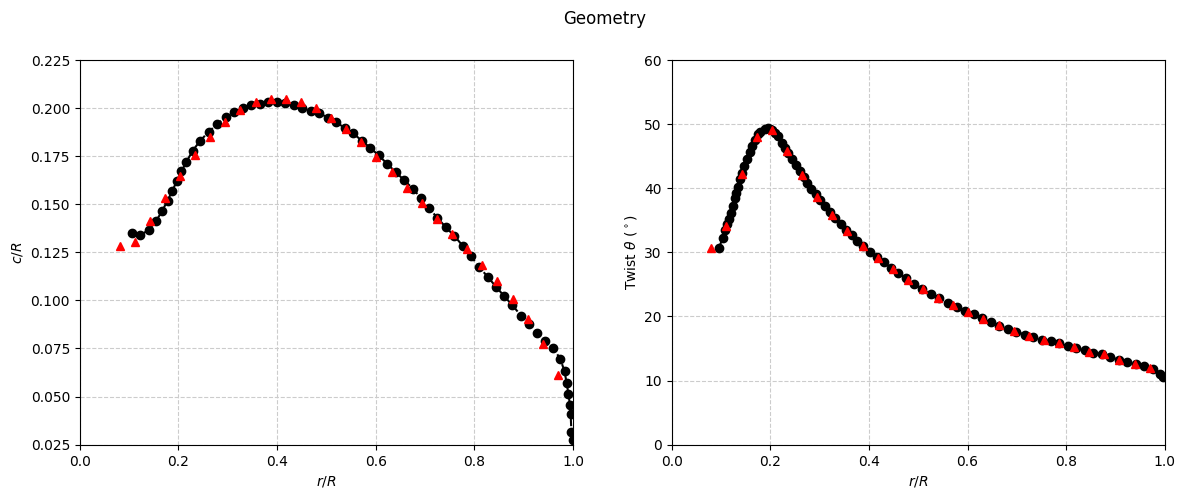

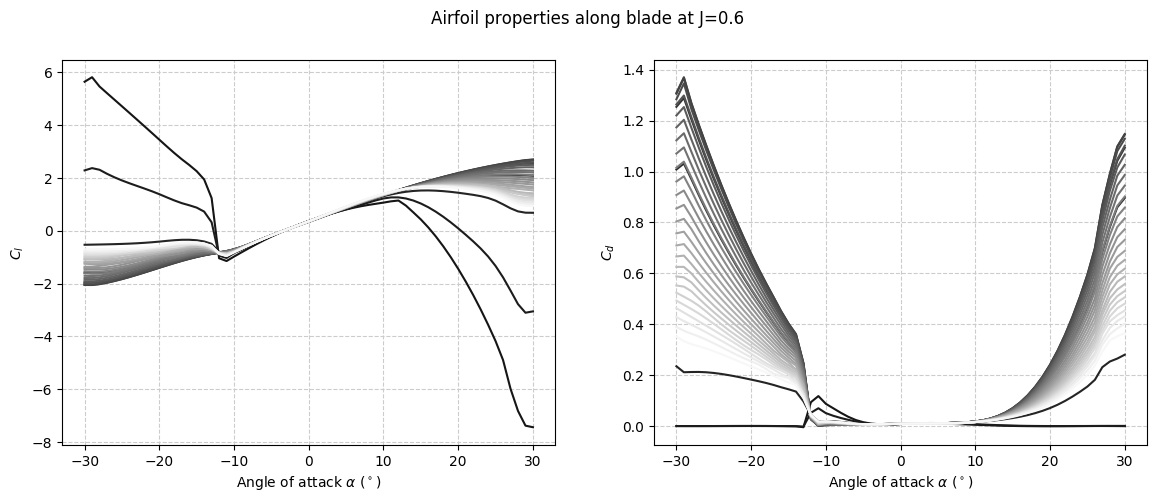

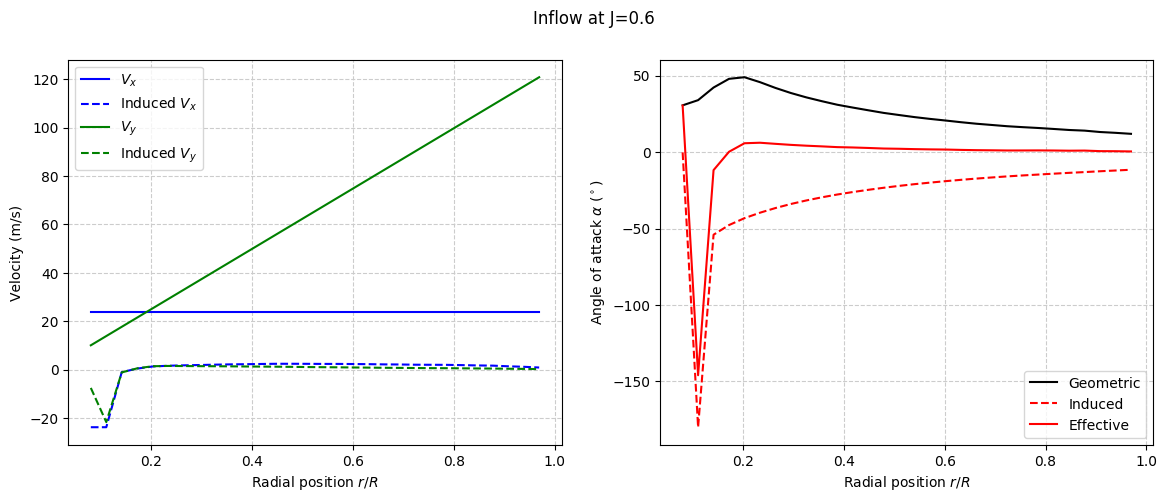

In [111]:

# ------------------ PLOTS ---------------------------------
# GEOMETRY
fig0 = figure("geom", figsize=(7*2, 5*1))
suptitle("Geometry")

## Chord along blade
subplot(121)
plot(data_chord[1]/Rtip, data_chord[2]/Rtip, "--ok",label="Data")
plot(r/Rtip, chord/Rtip, "^r",label="Spline")
xlabel(L"$r/R$")
ylabel(L"$c/R$")
xlim([0,1])
ylim([0.025,0.225])
grid(true, color="0.8", linestyle="--")

## Twist along blade
subplot(122)
plot(data_twist[1]/Rtip, data_twist[2], "--ok",label="Data")
plot(r/Rtip, theta*180/pi, "^r",label="Spline")
xlabel(L"$r/R$")
ylabel(L"Twist $\theta$ ($^\circ$)")
xlim([0,1])
ylim([0,60])
grid(true, color="0.8", linestyle="--")




# Plots airfoil data used at each radial position
plot_i = 12
plot_J = Js[plot_i]
alphas = [i for i in -30:1:30]
# alphas = [i for i in -180:1:180]
fig1 = figure("airfoil_data", figsize=(7*2, 5*1))
suptitle("Airfoil properties along blade at J=$plot_J")
            
for (i,this_af) in enumerate(afs[plot_i])
    subplot(121)
    plot(alphas, [this_af.cl(a*pi/180) for a in alphas], "$(r[i]/Rtip)")
    subplot(122)
    plot(alphas, [this_af.cd(a*pi/180) for a in alphas], "$(r[i]/Rtip)")
end
            
subplot(121)
xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
ylabel(L"C_l")
grid(true, color="0.8", linestyle="--")
# xlim([-20, 20])
subplot(122)
xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
ylabel(L"C_d")
grid(true, color="0.8", linestyle="--")


# Plots inflow
fig3 = figure("inflow", figsize=(7*2, 5*1))
suptitle("Inflow at J=$plot_J")
subplot(121)
plot(r/Rtip, inflows[plot_i].Vx, "-b", label=L"V_x")
plot(r/Rtip, uvecs[plot_i], "--b", label=L"Induced $V_x$")
plot(r/Rtip, inflows[plot_i].Vy, "-g", label=L"V_y")
plot(r/Rtip, vvecs[plot_i], "--g", label=L"Induced $V_y$")
xlabel(L"Radial position $r/R$")
ylabel("Velocity (m/s)")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

# Plots effective angle of attack
subplot(122)
plot(r/Rtip, 180/pi*theta, "-k", label="Geometric")
plot(r/Rtip, -180/pi*(atan2.(inflows[plot_i].Vx+uvecs[plot_i], 
                    inflows[plot_i].Vy+vvecs[plot_i])),
        "--r", label="Induced")
plot(r/Rtip, 180/pi*(theta-atan2.(inflows[plot_i].Vx+uvecs[plot_i], 
                    inflows[plot_i].Vy+vvecs[plot_i])),
        "-r", label="Effective")
xlabel(L"Radial position $r/R$")
ylabel(L"Angle of attack $\alpha$ ($^\circ$)")
legend(loc="best")
grid(true, color="0.8", linestyle="--")

### Results


<img src="figures/apc04.png" alt="Pic here" width="400px"/>
<img src="figures/apc05.png" alt="Pic here" width="800px"/>

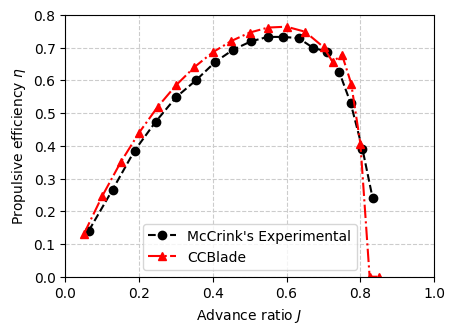

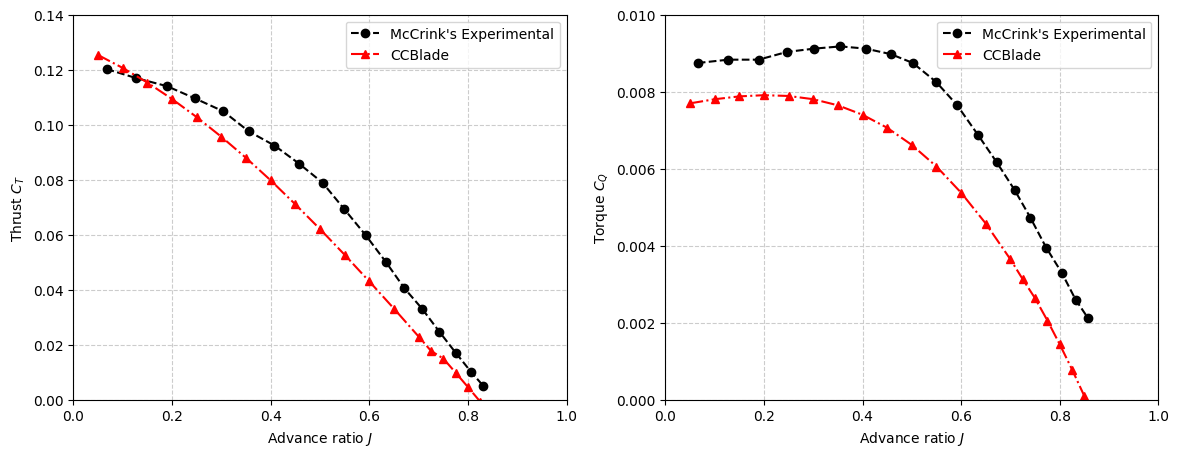

PyObject <matplotlib.legend.Legend object at 0x7f3ed5f46d10>

In [112]:
# PROPULSIVE EFFICIENCY
data_eta = CSV.read("data/apc10x7_eta.csv", header=["J","eta"], datarow=1)

fig1 = figure("eta", figsize=(7*0.68, 5*0.68))
plot(data_eta[1], data_eta[2], "--ok", label="McCrink's Experimental")
plot(Js, etas, "-.^r", label="CCBlade")
xlim([0, 1])
ylim([0, 0.8])
xlabel(L"Advance ratio $J$")
ylabel(L"Propulsive efficiency $\eta$")
grid(true, color="0.8", linestyle="--")
legend(loc="best")

# THRUST AND TORQUE COEFFICIENTS
data_CT = CSV.read("data/apc10x7_CT.csv", header=["J","CT"], datarow=1)
data_CQ = CSV.read("data/apc10x7_CQ.csv", header=["J","CQ"], datarow=1)

fig2 = figure("CTCQ", figsize=(7*2, 5*1))

## Thrust
subplot(121)
plot(data_CT[1], data_CT[2], "--ok", label="McCrink's Experimental")
plot(Js, CTs, "-.^r", label="CCBlade")
xlim([0, 1])
ylim([0, 0.14])
xlabel(L"Advance ratio $J$")
ylabel(L"Thrust $C_T$")
grid(true, color="0.8", linestyle="--")
legend(loc="best")

## Torque
subplot(122)
plot(data_CQ[1], data_CQ[2], "--ok", label="McCrink's Experimental")
plot(Js, CQs, "-.^r", label="CCBlade")
xlim([0, 1])
ylim([0, 0.01])
xlabel(L"Advance ratio $J$")
ylabel(L"Torque $C_Q$")
grid(true, color="0.8", linestyle="--")
legend(loc="best")

## Sketchbook (Ignore this)

### Airfoils - Ballard and Caradonna

In [65]:
run_this = false
foil_name = "naca0012_2"
# xfoil_polar = "xf-n0012-il-500000-n5.csv"
xfoil_polar = "xf-naca0012-18e6-n9.csv"

if run_this
    include("../../airfoil/src/airfoilprep.jl")
    ap = airfoilprep

    println(pwd())
#     polar = ap.read_polar(xfoil_polar; path="airfoils")
    polar = ap.read_polar2(xfoil_polar; path="airfoils")
    polar = ap.injective(polar)

    tsr = nothing
    for (i,ri) in enumerate(r)
        r_over_R = ri/Rtip
        c_over_r = chord[i]/ri

        this_polar = ap.correction3D(polar, r_over_R, chord[i]/ri, nothing)
        this_polar = ap.extrapolate(this_polar, 1.3)
        this_polar = ap.injective(this_polar)

        file_name = foil_name*"-roR$(Int(round(r_over_R,3)*1000))-cor$(Int(round(c_over_r,3)*1000))"
        file_name *= "-tsr$(tsr==nothing ? "Null" : Int(round(tsr,3)*1000))"
        ap.save_polar2(this_polar, file_name, path="airfoils/naca0012")
    end


    this_polar = ap.extrapolate(polar, 1.3)
    ap.save_polar2(this_polar, foil_name*"-orig", path="airfoils/naca0012")
end

### Airfoils - APC 10x7

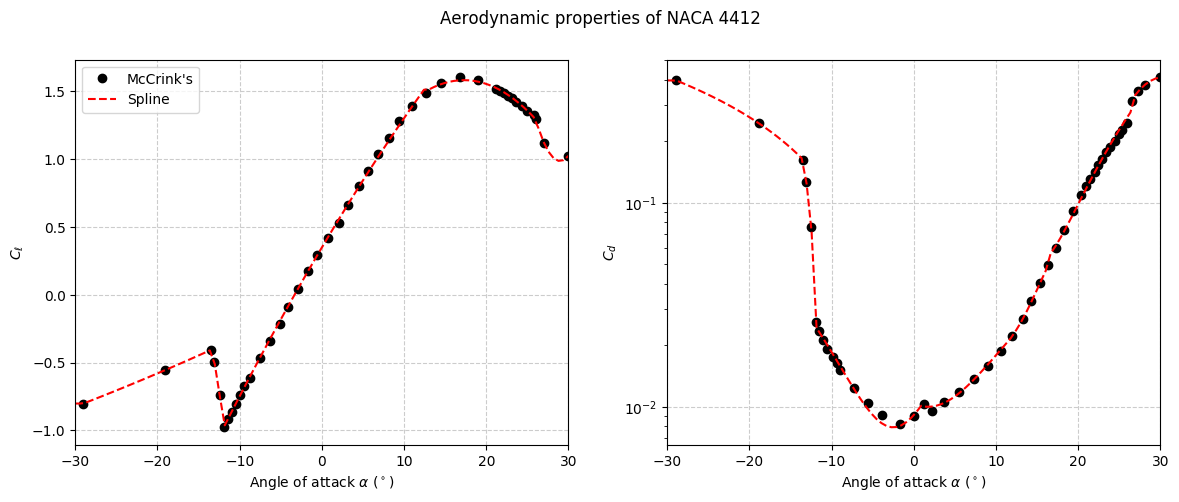

In [116]:
run_this = false
foil_name = "naca4412"

if run_this
    include("../../airfoil/src/airfoilprep.jl")
    ap = airfoilprep
    
    # Reads curves
    data_cl = CSV.read("airfoils/naca4412/NACA4412_cl.csv", datarow=1)
    data_cd = CSV.read("airfoils/naca4412/NACA4412_cd.csv", datarow=1)

    # Splines
    spl_k = 5
    spl_s = 0.1
    cl_secs = [1, 3, 6, 29, size(data_cl[1],1)-3, size(data_cl[1],1)]
    cd_secs = [1, 3, 6, 18, 25, 29, size(data_cd[1],1)-3, size(data_cd[1],1)]

    cl_spls = [Dierckx.Spline1D(data_cl[1][cl_secs[i-1]:cl_secs[i]], 
                                data_cl[2][cl_secs[i-1]:cl_secs[i]]; 
                                k= (cl_secs[i-1]-cl_secs[i]+1) >= spl_k ? spl_k : 2, s=spl_s)
                                                    for i in 2:size(cl_secs,1)]

    cd_spls = [Dierckx.Spline1D(data_cd[1][cd_secs[i-1]:cd_secs[i]], 
                                data_cd[2][cd_secs[i-1]:cd_secs[i]]; 
                                k= (cd_secs[i-1]-cd_secs[i]+1) >= spl_k ? spl_k : 2, s=spl_s)
                                                    for i in 2:size(cd_secs,1)]

    function fun_cl(a)
        for (i,cl_sec) in enumerate(cl_secs[2:end])
            if a<=data_cl[1][cl_sec]
                return cl_spls[i](a)
            end
        end
        error("Invalid angle $a")
    end
    function fun_cd(a)
        for (i,cd_sec) in enumerate(cd_secs[2:end])
            if a<=data_cd[1][cd_sec]
                return cd_spls[i](a)
            end
        end
        error("Invalid angle $a")
    end

    alphas = linspace(-30, 30, 100)
    cls = [fun_cl(a) for a in alphas]
    cds = [fun_cd(a) for a in alphas]
    
    # Plots
    fig = figure("clcd", figsize=(7*2, 5*1))

    subplot(121)
    plot(data_cl[1], data_cl[2], "ok", label="McCrink's")
    plot(alphas, cls, "--r", label="Spline")
    xlim([-30, 30])
    xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
    ylabel(L"C_\ell")
    grid(true, color="0.8", linestyle="--")
    legend(loc="best")

    subplot(122)
    semilogy(data_cd[1], data_cd[2], "ok", label="McCrink's")
    plot(alphas, cds, "--r", label="Spline")
    xlim([-30, 30])
    xlabel(L"Angle of attack $\alpha$ ($^\circ$)")
    ylabel(L"C_d")
    grid(true, color="0.8", linestyle="--")
    suptitle("Aerodynamic properties of NACA 4412");
        
    # Mach correction
    Ma_corr(cl_M0, M) = cl_M0./sqrt.(1-M.^2)
    
    min_i = 4
    
    for J in Js
        tsr = pi/J
        for (i,ri) in enumerate(r)
#             Vinf = J*Omega/(2*pi)*D
#             tsr = Omega*ri/Vinf
            r_over_R = ri/Rtip
            c_over_r = chord[i]/ri
            Ma = Matip*r_over_R


            this_polar = ap.Polar(1.5e6, alphas, Ma_corr(cls, Ma), cds, zeros(cls), [], [])
            this_polar = ap.correction3D(this_polar, r_over_R, chord[i]/ri, tsr)
#             this_polar = ap.correction3D(this_polar, i<min_i ? r[min_i]/Rtip : r_over_R, 
#                                                     i<min_i ? chord[min_i]/r[min_i] : chord[i]/ri,
#                                                         tsr)
            this_polar = ap.extrapolate(this_polar, 1.3)
            this_polar = ap.injective(this_polar)

            file_name = foil_name*"-roR$(Int(round(r_over_R,3)*1000))-cor$(Int(round(c_over_r,3)*1000))"
            file_name *= "-tsr$(tsr==nothing ? "Null" : Int(round(round(tsr,3)*1000,0)))"
            ap.save_polar2(this_polar, file_name, path="airfoils/naca4412")
        end
    end
    
end